## Obenhaus et al. - Fig. 1 

Plots related to Fig. 1 D and E (traces and cell map)

In [2]:
# Set up basics
import sys, os
import numpy as np 
import datajoint as dj
from IPython.display import display

In [3]:
sys.path.append('..')
from dj_schemas.utils import *

Connecting horsto@kavlidatajoint02.it.ntnu.no:3306


In [4]:
Session.database # should be `group_shared_topopaper_main_imaging'`

'group_shared_topopaper_main_imaging'

In [5]:
# Make plots pretty 
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='white')
%config InlineBackend.figure_format = 'retina'

In [6]:
# To prevent bug in figure export as pdf: 
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from mpl_toolkits.axes_grid1 import make_axes_locatable
def now():
    # New time every minute
    return datetime.strftime(datetime.now(),'%d_%m_%Y %H_%M')

In [7]:
# Standard figure export directory:
figure_dir = 'YOUR_EXPORT_DIRECTORY'

### Filter sessions / cells

In [8]:
# Choose one session
session_name = "1f20835f09e28706"
Session & f'session_name = "{session_name}"'

metasession_name Meta session name (hash),session_order Order of session within meta sessions (zero index!),"session_name Session name: Hash of animal_id, datasource_id, timestamp and combined 'yes'/'no' label",animal_id,datasource_id,animal_name Animal name in mlims,timestamp,combined,timeseries_name Timeseries name [e.g. MUnit_0],experiment_type,username NTNU username
5e192857bec0c163,0,1f20835f09e28706,ecbacf7da55524de,0,88592,2019-12-12 17:11:19,yes,88592-openfield,2Pminiscope_A,horsto


In [9]:
# Filter for some cells
cells = FilteredSpikes.proj('filtered_spikes') * Cell.Traces.proj('df_f','fcorr') * SNR & cell_parameter_dict & 'snr_df_f > 4' & f'session_name = "{session_name}"'
sync = MetaSession.Setup * Setup.Sync * Sync & f'session_name = "{session_name}"'
sync_frames, sample_rate_frame_sync = (sync & 'generic_name = "frames_imaging"').fetch1('sync_data','sample_rate')
timeline_frames = sync_frames / sample_rate_frame_sync

print(f'Found {len(cells)} cells')

Found 214 cells


In [10]:
# Plot the following cells
cell_ids = [12,16,25,47,60,84,85,88,90,95,96,98,144,155,156,157,194,202,220,329]
cell_keys = (cells & [f'cell_id = "{cell}"' for cell in cell_ids]).proj().fetch('KEY', as_dict=True)

In [11]:
# Quick SNR stats
snrs = ((SNR & cell_keys).proj('snr_df_f')).fetch('snr_df_f')
snrs.max(), snrs.min()

(12.521681, 5.1860404)

In [12]:
zoom_min, zoom_max = 350, 410 # Zoom window time in seconds

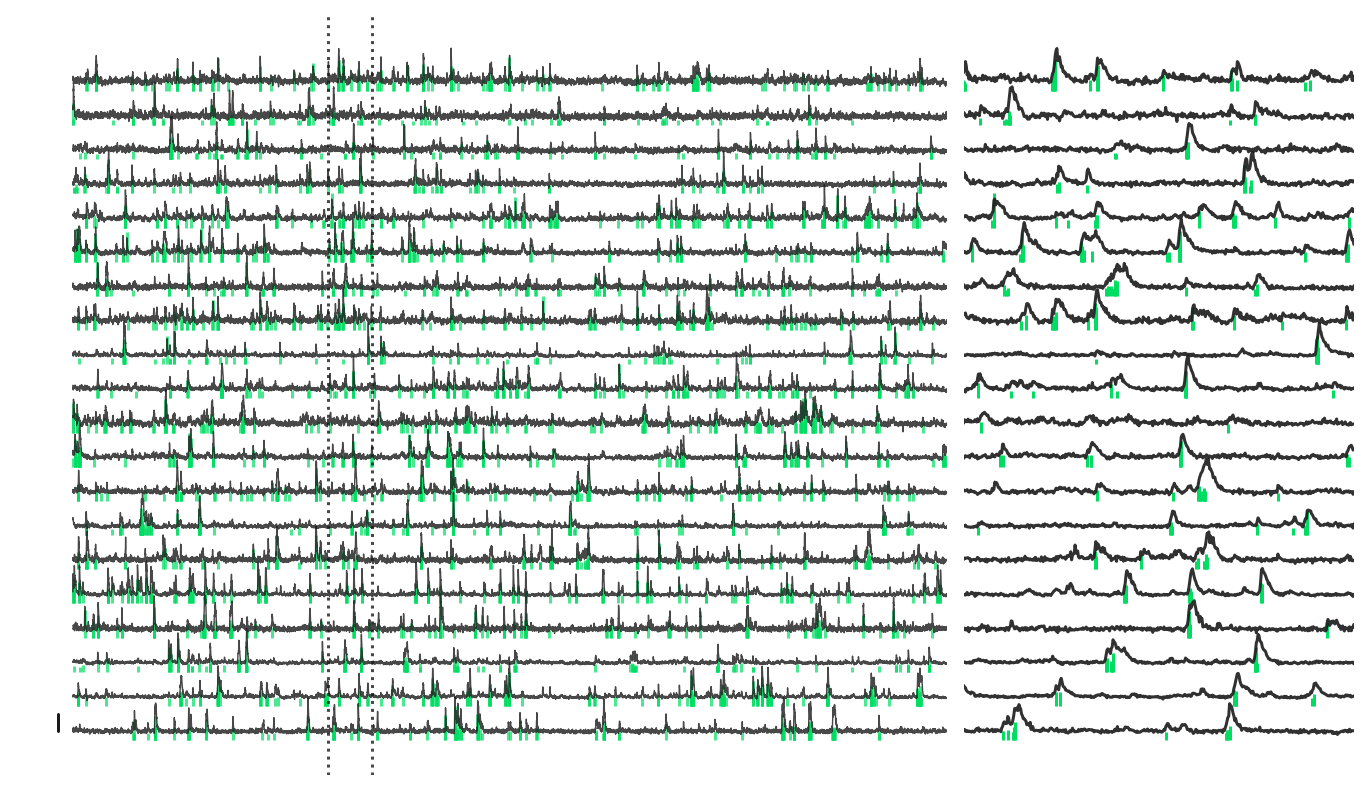

In [13]:
sns.set(style='white', font_scale=1.4)
figure = plt.figure(constrained_layout=False, figsize=(12,7))
gs = figure.add_gridspec(nrows=1, ncols=10, wspace=.15)
ax_all_traces = figure.add_subplot(gs[0, :7])   
ax_zoom       = figure.add_subplot(gs[0, 7:])   

color_spikes = '#00dd62'

for no, cell in enumerate(cell_keys):    
    df_f, spikes = (cells & cell).fetch1('df_f','filtered_spikes')
    df_f   = df_f.copy()
    spikes = spikes.copy()
    spikes /= spikes.max()
    max_df_f = df_f.max()
    df_f /= max_df_f
    
    ax_all_traces.plot(timeline_frames, df_f + no, color='k', lw=.7, alpha=.8)
    ax_all_traces.vlines(timeline_frames[spikes>0], no-.25, no-.25 + spikes[spikes>0], color=color_spikes, alpha=.7)
    ax_zoom.plot(timeline_frames, df_f + no, color='k', alpha=.9)
    ax_zoom.vlines(timeline_frames[spikes>0], no-.25, no-.25 + spikes[spikes>0], color=color_spikes)
    
    #ax_all_traces.text(-30, no, f'{cell["cell_id"]}', horizontalalignment='right')
    
    if not no: # draw y scale bar
        pass
    
    
ax_all_traces.axvline(x=zoom_min, lw=1.5, color='k', ls=':', alpha=.8)        
ax_all_traces.axvline(x=zoom_max, lw=1.5, color='k', ls=':', alpha=.8) 

ax_all_traces.set_xlim(-80,timeline_frames[-1])
ax_zoom.set_xlim(zoom_min,zoom_max)
ax_all_traces.get_yaxis().set_ticks([])
ax_zoom.get_yaxis().set_ticks([])
ax_zoom.get_xaxis().set_ticks([])
ax_all_traces.get_xaxis().set_ticks([])

ax_all_traces.plot([-20,-20],[0,.5], ls='-', color='k')

sns.despine(left=True, bottom=True)

figure.savefig(figure_dir + f'traces {now()}.png', dpi=300, bbox_inches='tight')

In [14]:
figure_dir

'YOUR_EXPORT_DIRECTORY'

In [15]:
from dj_plotter import dj_plotter
from dj_plotter.helpers.plotting_helpers import make_linear_colormap

In [16]:
cells = Session * ProjectionCorr * RoisCorr * SNR.proj('snr_df_f') & cell_keys
snr_df_f_cells = cells.fetch('snr_df_f')
colors = make_linear_colormap(snr_df_f_cells, cmap='viridis', reference_numbers=np.linspace(0, snr_df_f_cells.max()))

Drawing ROIs:   0%|          | 0/20 [00:00<?, ?it/s]

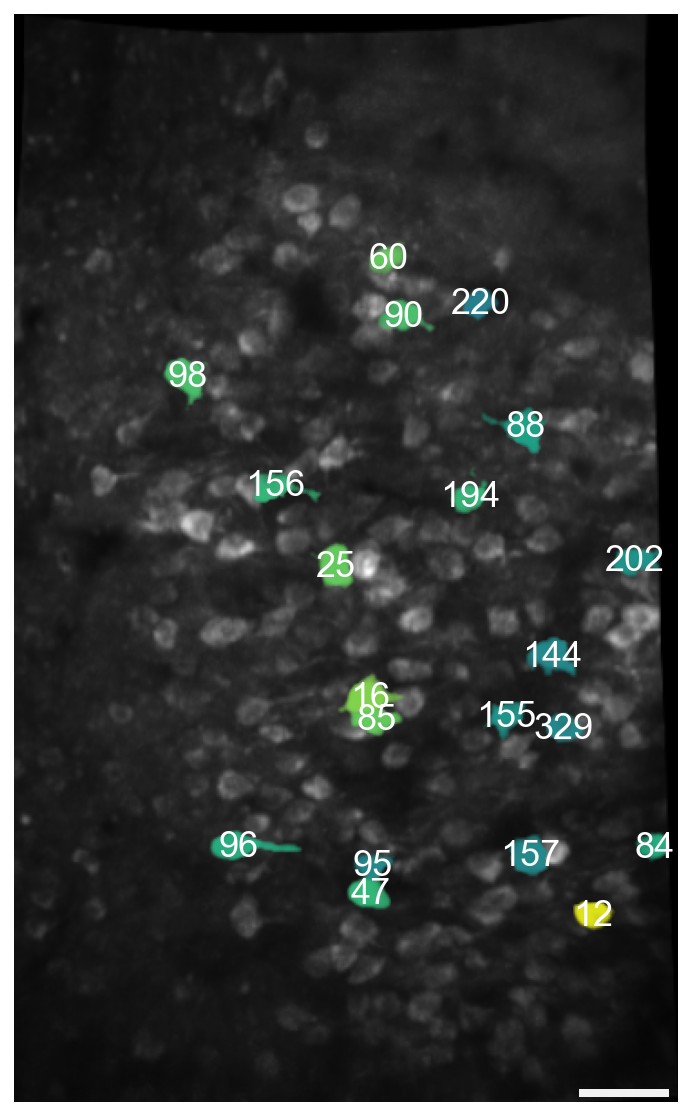

In [17]:
plot = dj_plotter(cells)

ax = plot.rois(draw_image=True, draw_pixels=True, draw_numbers=True,text_color='#fff', \
          draw_centers=False, draw_outlines=False, colors=colors, return_axes=True, \
          invert_img_cmap=False, display_title=False, fontsize=18, scalebar=50.)